# Exploratory Analysis of scRNA Datasets & GPU Scaling

Copyright (c) 2020, NVIDIA CORPORATION.  All rights reserved.

NVIDIA CORPORATION and its licensors retain all intellectual property
and proprietary rights in and to this software, related documentation
and any modifications thereto.  Any use, reproduction, disclosure or
distribution of this software and related documentation without an express
license agreement from NVIDIA CORPORATION is strictly prohibited.

This notebook demonstrates an exploratory single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata

import sys
import time
import os

import cudf
import cupy as cp

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans


import tables

import rapids_scanpy_funcs
import load_data

import warnings
warnings.filterwarnings('ignore', 'Expected column ')

In [2]:
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

cluster = LocalCUDACluster()
client = Client(cluster)
client



bokeh.server.util - WARNING - Host wildcard '*' will allow connections originating from multiple (or possibly all) hostnames or IPs. Use non-wildcard values to restrict access explicitly


Client Scheduler: tcp://127.0.0.1:46860 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 50.39 GB


## Set parameters

In [3]:
# marker genes
RIBO_GENE_PREFIX = "RPS" # Prefix for ribosomal genes to regress out
markers = ["ACE2", "TMPRSS2", "EPCAM"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
n_top_genes = 5000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 20 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Louvain
louvain_resolution = 0.4

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

In [4]:
start = time.time()

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 
 
To convert your CSV file into an `h5ad` file, see `csv_to_h5ad.ipynb`

In [5]:
one_mil_file = "../scrna_poc/data/1M_neurons_filtered_gene_bc_matrices_h5.h5"

In [6]:
import h5py

f = h5py.File(one_mil_file, mode="r")

In [7]:
dset = f["mm10"]
columnptr = dset["indptr"][:]

In [8]:
nnz = columnptr[-1]
print("NNZ: %s" % nnz)

NNZ: 2624828308


In [9]:
print("Shape: %s" % (dset["shape"][:]))

Shape: [  27998 1306127]


In [10]:
print("Density: %s" % (dset["data"].shape[0] / np.product(dset["shape"][:])))

Density: 0.0717775259310603


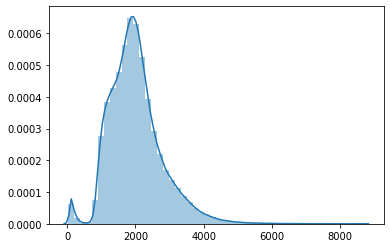

In [11]:
import seaborn as sns
sns.distplot(np.diff(columnptr))

In [12]:
import scipy

### Scaling File Loading

In [13]:
def _worker_part(filename, part, n_workers, rows_per_part=None):
    ## Divide rows into n_workers parts & load parts
    import h5py
    
    print("Opening " + str(filename))

    f = h5py.File(filename, mode="r")
    dset = f["mm10"]
    columnptr = dset["indptr"][:]
    
    total_rows = dset["shape"][1]
    rows_per_part = int(total_rows / n_workers) if rows_per_part is None else rows_per_part
    
    if rows_per_part * part > total_rows:
        rows_per_part = total_rows - (rows_per_part * part)
    
    
    
    start_idx = part * rows_per_part
    stop_idx = start_idx + rows_per_part
    
    if stop_idx >= len(columnptr):
        stop_idx = len(columnptr)-1
    
    start_ind = columnptr[start_idx]
    stop_ind = columnptr[stop_idx]

    inds = dset["indices"]
    with inds.astype(np.int32):
        out = inds[start_ind:stop_ind]
    
    data = dset["data"]
    with data.astype(np.float32):
        out_data = data[start_ind:stop_ind]
        
    ## Load into a sparse Dask array
    rowptr = np.zeros((rows_per_part+1,), dtype=cp.int32)
    
    c = columnptr[start_idx:stop_idx+1]
    
    cumsum = np.cumsum(np.diff(c))
    rowptr[1:] = cumsum
    
    ret = scipy.sparse.csr_matrix((out_data, out, rowptr), 
                                   shape=(rows_per_part, dset["shape"][0]))
    
    print(str(ret.shape))
    return ret
    
    

In [14]:
import dask
import dask.array as da
import math

nnz = 2624828308

load_part = dask.delayed(_worker_part)

n_parts = 10
final_shape = tuple(dset["shape"][:][::-1])
parts = [da.from_delayed(load_part(one_mil_file, i, n_parts), dtype=cp.float32, shape=(-1, final_shape[1])) for i in range(n_parts)]


print(str(final_shape))

final_arr = da.concatenate(parts)

(1306127, 27998)


In [ ]:
final_arr.compute_chunk_sizes()

In [ ]:
final_arr

In [17]:
def conv_to_cp_csr(x):
    
    print(str(type(x)))
    indptr = cp.array(x.indptr)
    indices = cp.array(x.indices)
    data = cp.array(x.data)
    
    return cp.sparse.csr_matrix((data, indices, indptr))

final_arr = final_arr.map_blocks(conv_to_cp_csr, meta=cp.sparse.csr_matrix(cp.zeros(1)))

In [18]:
def _filter_cells(sparse_matrix, min_genes=200, max_genes=6000):
    """
    Since data is distributed by row, filtering can be done embarrassingly parallel
    """
    return rapids_scanpy_funcs.filter_cells(sparse_matrix, 
                                            min_genes=min_genes_per_cell, 
                                            max_genes=max_genes_per_cell)

In [ ]:
final_arr = final_arr.persist()

In [19]:
final_arr = final_arr.map_blocks(lambda x: _filter_cells(x, min_genes=200, max_genes=6000), meta=cp.sparse.csr_matrix(cp.zeros(1)))

In [20]:
gene_counts = final_arr.map_blocks(lambda x: x.sum(axis=0), meta=cp.sparse.csr_matrix(cp.zeros(1)))

In [21]:
gene_counts = np.asarray(gene_counts.compute().sum(axis=0) > 0).ravel()

In [22]:
def _filter_genes(sparse_gpu_array, thr):
    print(str(sparse_gpu_array.shape))
    return sparse_gpu_array[:,thr]

final_arr = final_arr.map_blocks(lambda x: _filter_genes(x, gene_counts), meta=cp.sparse.csr_matrix(cp.zeros(1)))

In [23]:
final_arr = final_arr.persist()

In [24]:
def _normalize_total(filtered, target_sum=1e4):
    return rapids_scanpy_funcs.normalize_total(filtered, target_sum=target_sum)

In [25]:
final_arr = final_arr.map_blocks(lambda x: _normalize_total(x, target_sum=1e4), meta=cp.sparse.csr_matrix(cp.zeros(1)))

In [29]:
def _log1p(normalized):
    return normalized.log1p()

In [30]:
final_arr = final_arr.map_blocks(_log1p, meta=cp.sparse.csr_matrix(cp.zeros(1)))

In [31]:
final_arr = final_arr.persist()

In [32]:
final_arr[0].compute()

NameError: name 'normalized' is not defined

## Count Matrix Generation
Naive count matrix generation just for scale testing. This is meant to be fast to generate. The joint distribution of counts between cells and genes is not based on a real count matrix.

Guarantees:
- The counts follow a negative binomial distribution
- A valid CSR array will result, so columns will already be sorted

In [5]:
%%time
n_rows = 280_000
n_cols = 100_000
mean = 2000
std_dev = 1000 # clipped to x > 0

density = 0.074727

import generate_data

adata = generate_data.generate_cellxgene_naive(
   n_rows=n_rows, 
   n_cols=n_cols, 
   target_density=density, 
   include_genes=[]
)

actual NNZ: 2092215937
actual density: 0.074722
Generated 10000 out of 280000 rows.
Generated 20000 out of 280000 rows.
Generated 30000 out of 280000 rows.
Generated 40000 out of 280000 rows.
Generated 50000 out of 280000 rows.
Generated 60000 out of 280000 rows.
Generated 70000 out of 280000 rows.
Generated 80000 out of 280000 rows.
Generated 90000 out of 280000 rows.
Generated 100000 out of 280000 rows.
Generated 110000 out of 280000 rows.
Generated 120000 out of 280000 rows.
Generated 130000 out of 280000 rows.
Generated 140000 out of 280000 rows.
Generated 150000 out of 280000 rows.
Generated 160000 out of 280000 rows.
Generated 170000 out of 280000 rows.
Generated 180000 out of 280000 rows.
Generated 190000 out of 280000 rows.
Generated 200000 out of 280000 rows.
Generated 210000 out of 280000 rows.
Generated 220000 out of 280000 rows.
Generated 230000 out of 280000 rows.
Generated 240000 out of 280000 rows.
Generated 250000 out of 280000 rows.
Generated 260000 out of 280000 rows.

MemoryError: std::bad_alloc: CUDA error at: /conda/conda-bld/librmm_1585667745908/work/include/rmm/mr/device/cuda_memory_resource.hpp66: cudaErrorMemoryAllocation out of memory

In [6]:
adata.var_names

NameError: name 'adata' is not defined

In [27]:
def _sum_genes(sparse_matrix, gene_names):
    """
    Since genes are along the columns, we can sum axis 1 individually, do a final sum
    on the client, and then send out the indices of zero genes for each one to filter. 
    """
    sum_of_zenes = []
    return sum_of_genes

In [28]:
def _filter_genes(sparse_matrix, gene_names, genes_to_filter):
    pass

In [29]:
def _normalize_total(sparse_matrix, gene_names, total=1e-4):
    """
    This should be super easy- just normalizing the columns to sum to 1e-4, another embarrassingly parallel op
    """
    pass

In [30]:
def _log1p(sparse_matrix, gene_names):
    """
    Another embarrassingly parallel op
    """
    pass

In [31]:
def _highly_variable(sparse_matrix, gene_names):
    """
    Could we take a sampling here? Maybe run a few samplings in parallel?
    """

In [32]:
def _regress_out():
    """
    This is going to need a transpose. We might be able to transpose this or do a sampling. 
    """

In [33]:
sparse_matrix, gene_names = _worker_part(one_mil_file, 0, 25, 10000)

NameError: name '_worker_part' is not defined

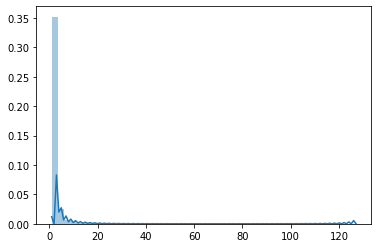

In [36]:
sns.distplot(sparse_matrix.data)

In [20]:
%%time
adata = sc.read(input_file)
adata = adata.T

NameError: name 'input_file' is not defined

In [142]:
adata.X.nnz / (adata.X.shape[0] * adata.X.shape[1])

0.0747219934

In [143]:
adata.shape

(50000, 100000)

We maintain the index of unique cells and genes in our dataset:

In [9]:
%%time
cells = cudf.Series(adata.obs_names)
genes = cudf.Series(adata.var_names)

CPU times: user 3.39 ms, sys: 124 µs, total: 3.52 ms
Wall time: 2.69 ms


In [10]:
%%time
rows = cp.array(adata.X.indptr)
cols = cp.array(adata.X.indices)
vals = cp.array(adata.X.data)
sparse_gpu_array = cp.sparse.csr_matrix((vals, cols, rows), shape=adata.X.shape)

CPU times: user 2.92 ms, sys: 1.82 ms, total: 4.74 ms
Wall time: 55.3 ms


Verify the shape of the resulting sparse matrix

In [36]:
sparse_gpu_array.shape

(5, 10000)

And the number of non-zero values n the matrix

In [37]:
sparse_gpu_array.nnz

3733

In [23]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

NameError: name 'data_load_start' is not defined

## Preprocessing

In [24]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [11]:
%%time
filtered = rapids_scanpy_funcs.filter_cells(sparse_gpu_array, 
                                            min_genes=min_genes_per_cell, 
                                            max_genes=max_genes_per_cell,
                                            rows_per_batch=20000)

Running 1 batches
CPU times: user 8.16 ms, sys: 56 µs, total: 8.21 ms
Wall time: 7.1 ms


In [12]:
filtered.shape

(5, 10000)

In [13]:
genes

0          ACE2
1       TMPRSS2
2         EPCAM
3             3
4             4
         ...   
9995       9995
9996       9996
9997       9997
9998       9998
9999       9999
Length: 10000, dtype: object

Some genes will now have zero expression in all cells. We filter out such genes.

In [14]:
%%time
filtered, genes = rapids_scanpy_funcs.filter_genes(filtered, genes, min_cells=1)

CPU times: user 9.45 ms, sys: 848 µs, total: 10.3 ms
Wall time: 9.02 ms


The size of our count matrix is now reduced.

In [15]:
genes

0         11
1         13
2         20
3         30
4         36
        ... 
2877    9974
2878    9981
2879    9984
2880    9990
2881    9998
Length: 2882, dtype: object

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [16]:
%%time
normalized = rapids_scanpy_funcs.normalize_total(filtered, target_sum=1e4)

CPU times: user 848 µs, sys: 11.6 ms, total: 12.5 ms
Wall time: 25.4 ms


Next, we log transform the count matrix.

In [17]:
%%time
normalized = normalized.log1p()

CPU times: user 5.69 ms, sys: 0 ns, total: 5.69 ms
Wall time: 4.73 ms


### Select Most Variable Genes

We convert the count matrix to an annData object.

In [18]:
genes

0         11
1         13
2         20
3         30
4         36
        ... 
2877    9974
2878    9981
2879    9984
2880    9990
2881    9998
Length: 2882, dtype: object

In [19]:
%%time
adata = anndata.AnnData(normalized.get())
adata.var_names = genes.to_pandas()

CPU times: user 7.36 ms, sys: 1.08 ms, total: 8.44 ms
Wall time: 7.43 ms


Using scanpy, we filter the count matrix to retain only the 5000 most variable genes.

In [20]:
%%time
sc.pp.highly_variable_genes(adata, n_top_genes=10, flavor="cell_ranger")
adata = adata[:, adata.var.highly_variable]

CPU times: user 179 ms, sys: 19.7 ms, total: 199 ms
Wall time: 195 ms


### Regress out confounding factors (number of counts, ribosomal gene expression)

We can now perform regression on the count matrix to correct for confounding factors -  for example purposes, we use the number of counts and the expression of ribosomal genes. Many workflows use the expression of mitochondrial genes (named starting with `MT-`).

Before regression, we save the 'raw' expression values of the ACE2 and TMPRSS2 genes to use for labeling cells afterward. We will also store the expression of n epithelial marker gene (EPCAM).

In [21]:
genes[genes == "ACE2"]

Series([], dtype: object)

In [22]:
%%time
tmp_norm = normalized.tocsc()
ACE2_raw = tmp_norm[:, genes[genes == "ACE2"].index[0]].todense().ravel()
TMPRSS2_raw = tmp_norm[:, genes[genes == "TMPRSS2"].index[0]].todense().ravel()
EPCAM_raw = tmp_norm[:, genes[genes == "EPCAM"].index[0]].todense().ravel()

del tmp_norm

IndexError: 

In [23]:
genes = adata.var_names
ribo_genes = adata.var_names.str.startswith(RIBO_GENE_PREFIX)

In [24]:
%%time
filtered = adata.X

CPU times: user 2.21 ms, sys: 47 µs, total: 2.26 ms
Wall time: 1.99 ms


We now calculate the total counts and the percentage of ribosomal counts for each cell.

In [25]:
%%time
n_counts = filtered.sum(axis=1)
percent_ribo = (filtered[:,ribo_genes].sum(axis=1) / n_counts).ravel()

n_counts = cp.array(n_counts).ravel()
percent_ribo = cp.array(percent_ribo).ravel()

CPU times: user 3.31 ms, sys: 148 µs, total: 3.45 ms
Wall time: 7.65 ms


/share/software/miniconda3/envs/rapids-env7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


And perform regression:

In [26]:
%%time
normalized = cp.array(adata.X.todense(), order="F")
normalized = rapids_scanpy_funcs.regress_out(normalized, n_counts, percent_ribo)

CPU times: user 157 ms, sys: 42.3 ms, total: 200 ms
Wall time: 4.57 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations, obtaining the preprocessed count matrix.

In [27]:
%%time
normalized = rapids_scanpy_funcs.scale(normalized, max_value=10)

CPU times: user 10.1 ms, sys: 2.04 ms, total: 12.1 ms
Wall time: 12.1 ms


In [28]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

NameError: name 'preprocess_start' is not defined

## Cluster & Visualize

In [29]:
cluster_start = time.time()

We store the preprocessed count matrix as an AnnData object, which is currently in host memory. We also add the expression levels of the marker genes as observations to the annData object.

In [30]:
%%time

var_names = adata.var_names
adata = anndata.AnnData(normalized.get())
adata.var_names = var_names
adata.obs["ACE2_raw"] = ACE2_raw.get()
adata.obs["TMPRSS2_raw"] = TMPRSS2_raw.get()
adata.obs["EPCAM_raw"] = EPCAM_raw.get()

NameError: name 'ACE2_raw' is not defined

In [31]:
adata.shape

(5, 54)

### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [ ]:
%%time
adata.obsm["X_pca"] = PCA(n_components=n_components).fit_transform(adata.X)

In [61]:
adata.obsm["X_pca"].shape

(69140, 50)

### TSNE + K-means

We next use t-SNE on the top 20 principal components to visualize the cells in two dimensions.

In [47]:
%%time
adata.obsm['X_tsne'] = TSNE().fit_transform(adata.obsm["X_pca"][:,:tsne_n_pcs])

/share/software/miniconda3/envs/rapids-env7/lib/python3.7/site-packages/cuml/utils/input_utils.py:188: UserWarning: Expected row ('C') major order, but got the opposite. Converting data, this will result in additional memory utilization.
  warnings.warn("Expected " + order_to_str(order) + " major order, "


CPU times: user 1.54 s, sys: 1.55 s, total: 3.08 s
Wall time: 3.3 s


We cluster the cells using k-means on the principal components. For example purposes, we set k=20.

In [48]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 346 ms, sys: 202 ms, total: 547 ms
Wall time: 581 ms


We visualize the cells using t-SNE and label cells by color according to the k-means clustering.

... storing 'kmeans' as categorical


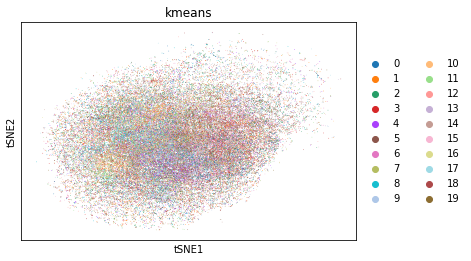

CPU times: user 800 ms, sys: 239 ms, total: 1.04 s
Wall time: 936 ms


In [49]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

Separately, we label the cells using the 'raw' expression of the EPCAM, ACE2 and TMPRSS2 marker genes.

KeyError: 'ACE2_raw'

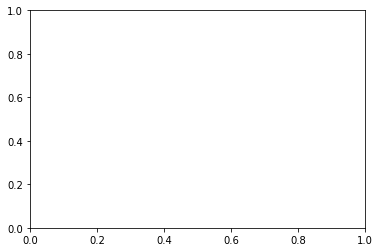

In [50]:
%%time
sc.pl.tsne(adata, size=4, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1,  vmin=-0.05)

### UMAP + Louvain

We can also visualize the cells using the UMAP algorithm in Rapids. Before UMAP, we need to construct a k-nearest neighbors graph in which each cell is connected to its nearest neighbors. This can be done conveniently using rapids functionality already integrated into Scanpy.

In [51]:
%%time
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')

Nearest neighbors time: 0.707308292388916
CPU times: user 6.28 s, sys: 624 ms, total: 6.9 s
Wall time: 7.66 s


The UMAP function from Rapids is also integrated into Scanpy.

In [45]:
%%time
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')

AscontiguousArrayTime: 0.0019767284393310547
UMAP TIME: 1.3149056434631348
CPU times: user 449 ms, sys: 228 ms, total: 677 ms
Wall time: 1.33 s


Finally, we use the Louvain algorithm for graph-based clustering, once again using the `rapids` option in Scanpy.

In [46]:
%%time
sc.tl.louvain(adata, resolution=louvain_resolution, flavor='rapids')

CPU times: user 174 ms, sys: 51.9 ms, total: 226 ms
Wall time: 452 ms


/share/software/miniconda3/envs/rapids-env7/lib/python3.7/site-packages/cugraph/structure/graph.py:329: UserWarning: add_adj_list will be deprecated in next release. Use from_cudf_adjlist instead
  Use from_cudf_adjlist instead')


We plot the cells using the UMAP visualization, and using the Louvain clusters as labels.

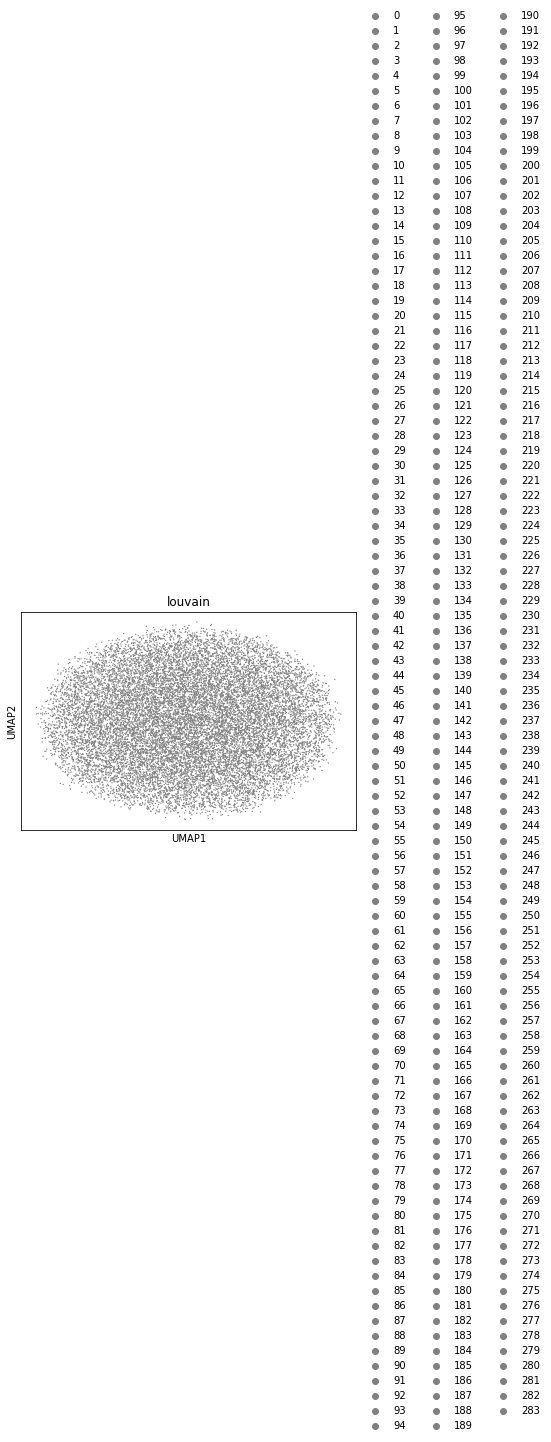

CPU times: user 2.11 s, sys: 196 ms, total: 2.31 s
Wall time: 2.19 s


In [47]:
%%time
sc.pl.umap(adata, color=["louvain"])

We can also view cells using UMAP and labeling by raw EPCAM, ACE2 and TMPRSS2 expression.

KeyError: 'ACE2_raw'

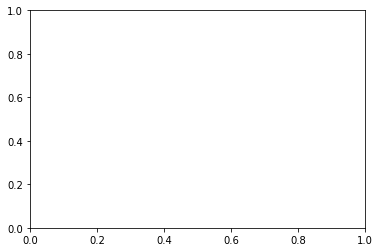

In [48]:
%%time
sc.pl.umap(adata, size=4,color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, size=4, color=["EPCAM_raw"], color_map="Reds", vmax=1, vmin=-0.05)

In [42]:
cluster_time = time.time()
print("Total cluster time : %s" % (cluster_time-cluster_start))

Total cluster time : 13.593403339385986


## Differential expression analysis

Once we have done clustering, we can compute a ranking for the highly differential genes in each cluster. Here we use the Louvain clusters as labels.

In [43]:
cluster_labels = cudf.Series.from_categorical(adata.obs["louvain"].cat)
var_names = cudf.Series(var_names)

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [44]:
%%time
scores, names, reference = rapids_scanpy_funcs.rank_genes_groups(
    normalized, 
    cluster_labels, 
    var_names, 
    n_genes=ranking_n_top_genes, groups='all', reference='rest')

GPU Ranking took: 5.4110612869262695
Created np.rec.fromarrays in: 14.490511178970337
CPU times: user 17.6 s, sys: 2.55 s, total: 20.2 s
Wall time: 19.9 s


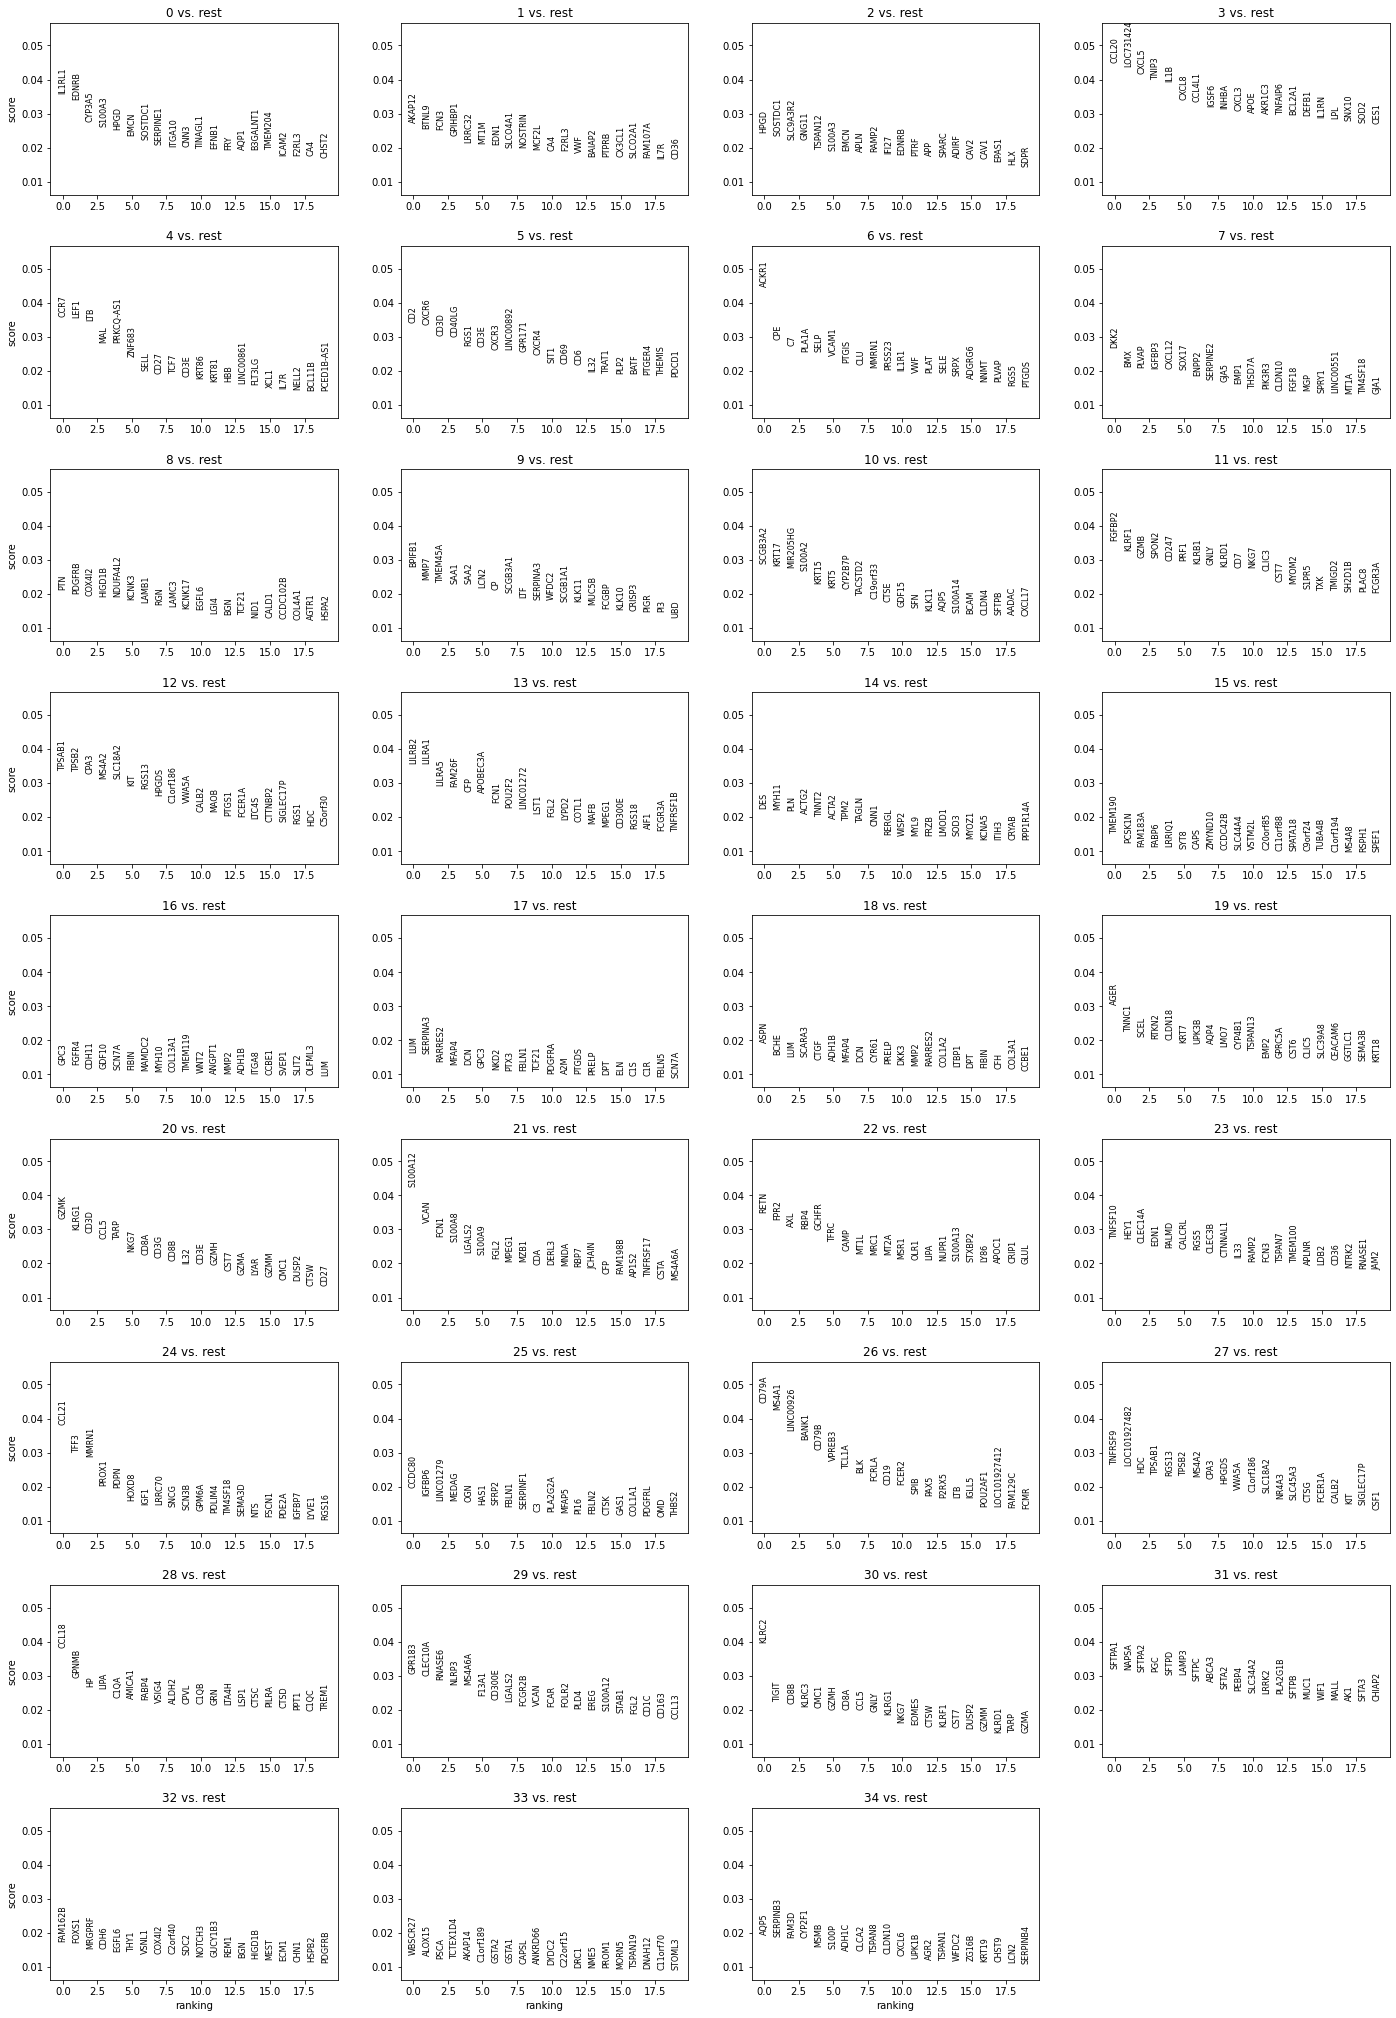

CPU times: user 5.63 s, sys: 812 ms, total: 6.44 s
Wall time: 5.84 s


In [45]:
%%time
adata.uns["rank_genes_groups"] = {}
adata.uns["rank_genes_groups"]["params"] = dict(groupby="louvain", method="logreg", reference=reference, use_raw=False)
adata.uns["rank_genes_groups"]['scores'] = scores
adata.uns["rank_genes_groups"]['names'] = names
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create Zoomed View

The speedup offered by Rapids makes it easy to interactively re-analyze subsets of cells. To illustrate this, we select epithelial cells (EPCAM+) from the dataset.

In [46]:
reanalysis_start = time.time()

In [47]:
%%time

epcam_cells = EPCAM_raw > 0.0

normalized_epcam_cells = normalized[epcam_cells]
ACE2_raw_epcam = ACE2_raw[epcam_cells]
TMPRSS2_raw_epcam = TMPRSS2_raw[epcam_cells]

var_names = adata.var_names
adata = anndata.AnnData(normalized_epcam_cells.get())
print(adata.X.shape)
adata.var_names = var_names
adata.obs["ACE2_raw"] = ACE2_raw_epcam.get()
adata.obs["TMPRSS2_raw"] = TMPRSS2_raw_epcam.get()

(7958, 5000)
CPU times: user 42.9 ms, sys: 51.3 ms, total: 94.2 ms
Wall time: 92.2 ms


We can repeat the dimension reduction, clustering and visualization using this subset of cells in seconds.

AscontiguousArrayTime: 0.0005648136138916016
UMAP TIME: 0.1491684913635254


/share/software/miniconda3/envs/rapids-env7/lib/python3.7/site-packages/cugraph/structure/graph.py:329: UserWarning: add_adj_list will be deprecated in next release. Use from_cudf_adjlist instead
  Use from_cudf_adjlist instead')


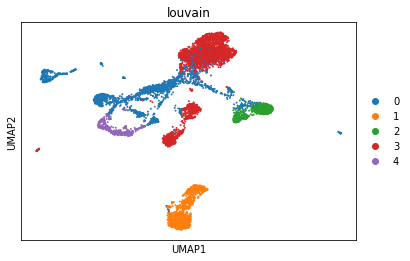

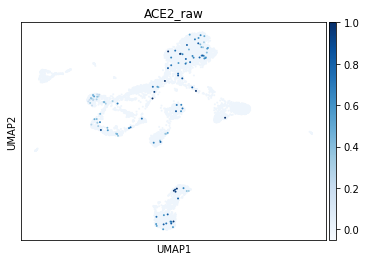

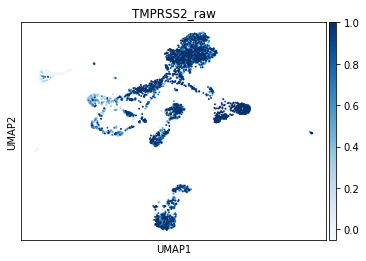

CPU times: user 12.2 s, sys: 1.38 s, total: 13.6 s
Wall time: 3.24 s


In [48]:
%%time

adata.obsm["X_pca"] = PCA(n_components=n_components).fit_transform(adata.X)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs, method='rapids')
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread, method='rapids')
sc.tl.louvain(adata, flavor='rapids')

sc.pl.umap(adata, color=["louvain"])
sc.pl.umap(adata, color=["ACE2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["TMPRSS2_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [49]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 3.365189552307129


In [50]:
print("Full time: %s" % (time.time() - start))

Full time: 95.06480646133423


In [51]:
client.close()
cluster.close()